<a href="https://colab.research.google.com/github/juanserrano90/codelatam/blob/main/DataPreparation/modules/add_spikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is a draft for the add_spikes module to be added to generate the modified copies.

Author: Paula GM, built over code by Willow Fox Fortino
Date: Oct. 20th, 2024
Last Modified: Oct. 20th, 2024.

In [9]:
import sys
from os.path import isfile

import numpy as np
import pandas as pd
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from scipy import stats

# from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import random

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# -- Authors: Paula Gálvez Molina
# -- Modified from original code by : Willow Fox Fortino
# Last Modified: Oct. 21th, 2024

def add_spikes(spectrum, redshift, start=2501.69, end=9993.24):
    """Loosely simulate telluric lines by adding in one-pixel wide spikes to the
       spectra are expected de-redshifted telluric lines.

        Args:
        spectrum (float): Supernova spectrum to be modified.
        redshift (float): Redshift of the supernova of the corresponding spectrum.
        start (float): Minimum wavelength of the telluric line.
        end (float): Maximum wavelength of the telluric line.

        Returns:
        spiked (array): Spectrum array with spike(s) added."""

    # First decide how many spikes should be added. At most 5 and at minimum zero.
    num_spikes = stats.randint.rvs(low=0, high=4, size=1).item()
    print('num',num_spikes)

    # Construct the array of spikes that is the same shape as the original spectrum.
    spiked = spectrum.copy() #FBB move this to before tell_loc

    # FBB put this in a if statements
    if num_spikes>0:
      # Next decide the location of the spikes by approximating the first spike at around 760 nm (O2 A-Band) with corresponding redshift.
      # If more than one spike, then the location is given by choosing a random number between 0 and the length of the array containing the spectrum. These other lines intend to simulate artifact.
      tell_loc = 7600 / (redshift + 1)

      # Find the edges of the mask and redefine start and end as those values
      filter = spiked != 0
      nonzero_indices = np.nonzero(filter)[0]
      startSpec, endSpec = nonzero_indices[0], nonzero_indices[-1]

      # The spectrums are in logarithmic scale, so the index of the location of the spike must be determined by the location of the in the logarithmic array closest in value to the tell_loc.
      log_array = np.logspace(np.log10(start), np.log10(end), num=len(spectrum))    # Create the logarithmically spaced array
      # FBB you should not need to recreate this: it should be an object defined in the speclc where you et the spectra from

      idx = (np.abs(log_array - tell_loc)).argmin()     # Find the index of the element closest to the given value
      spike_loc = stats.randint.rvs(low=startSpec, high=endSpec, size=num_spikes) # FBB removed random state: that is set outside of this function
      if np.random.rand() > 0.75: # 1/4 of the times
        spike_loc[0] = idx + np.random.randint(-2,2) # Not necessarily on the pixel of the telluric line but +- 2 pixels

      # Next, we decide if the spike will be an addition or subtraction (i.e., if the telluric line is emission or absorption). 80% of the time, the spike will be in emission (a positive spike) and the rest of the time it will be in absorption.
      spike_dir = stats.binom.rvs(n=1, p=0.80, size=num_spikes)
      spike_dir[spike_dir == 0] = -1

      # Finally choose the magnitude of the spike. We take the absolute value since we are having the sign of the spike determined by the previous set of code.
      # The standard deviations of the magnitude of the injected spikes will be tied to the standard deviation of the spectrum.
      spike_mag = np.abs(stats.norm.rvs(loc=0, scale=2*spectrum.std(), size=num_spikes))

      spiked[spike_loc] = spike_mag * spike_dir
      print('spike',spike_loc)
      print('mag',spike_mag)
      print('dir',spike_dir)

    return spiked

In [12]:
url = "https://github.com/juanserrano90/codelatam/raw/main/Data/data/sn_data.parquet"
df_raw = pd.read_parquet(url)

In [13]:
wavelength = np.array([float(c) for c in df_raw.columns[5:]])
# wavelength = range(len(sample1))

[2501.69 2505.08 2508.48 ... 9966.21 9979.71 9993.24]
1024
num 2
spike [662 497]
mag [0.07719868 0.27956597]
dir [1 1]
num 3
spike [816 548 583]
mag [0.00751282 0.14462957 0.1797985 ]
dir [ 1 -1  1]


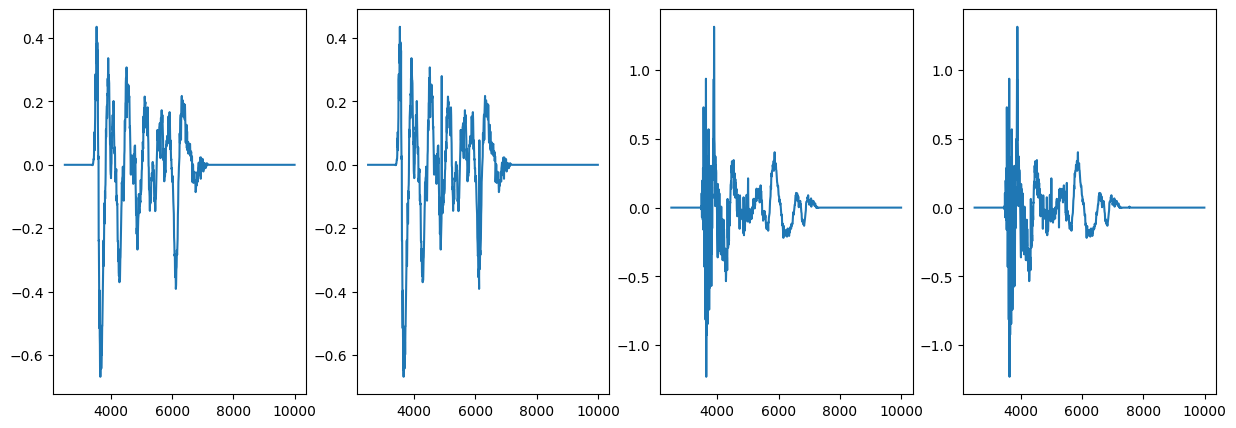

In [14]:
np.random.seed(42)
column_names = df_raw.columns.values.tolist()
column_names = np.array(column_names[5:]).astype(float)
print(column_names)
print(len(column_names))
diffs = column_names[1:] - column_names[:-1]
sample1 = df_raw.loc[(df_raw.index == "sn2008ar") * (df_raw["Spectral Phase"] == -4.6)].iloc[:, 5:].values[0]
spiked1 = add_spikes(sample1, 0.03)
sample2 = df_raw.loc[(df_raw.index == "sn2007uy") * (df_raw["Spectral Phase"] == 12.82)].iloc[:, 5:].values[0]
spiked2 = add_spikes(sample2, 0.005)


fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].plot(wavelength, sample1)
ax[1].plot(wavelength, spiked1)
ax[2].plot(wavelength, sample2)
ax[3].plot(wavelength, spiked2)


num 3
spike [334 240 370]
mag [0.14819101 0.44544731 0.06020694]
dir [1 1 1]
num 2
spike [620 499]
mag [0.2580286  0.08123495]
dir [1 1]
num 3
spike [724 712 458]
mag [0.35249987 0.01224511 0.10088937]
dir [1 1 1]
num 1
spike [818]
mag [0.1874657]
dir [-1]
num 3
spike [624 413 394]
mag [1.95227256 1.62697085 0.23663477]
dir [ 1  1 -1]


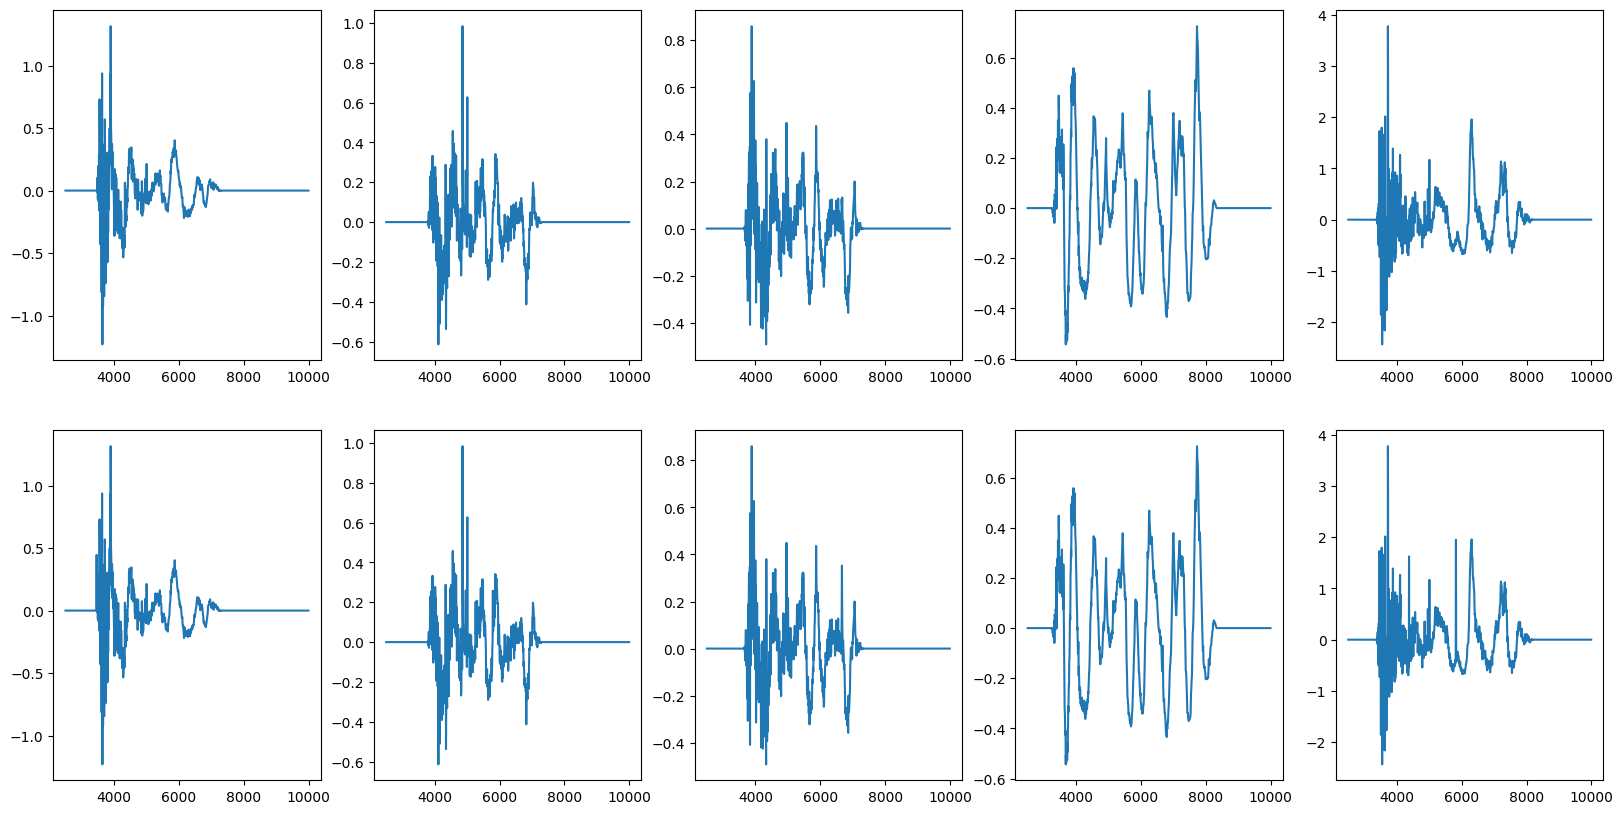

In [19]:
np.random.seed(3312)
column_names = df_raw.columns.values.tolist()
column_names = np.array(column_names[5:]).astype(float)

delay_phases = [12.82, 45.82, 54.82, 75.82, 141.82]
sample = []
for delay in delay_phases:
  sample.append(df_raw.loc[(df_raw.index == "sn2007uy") * (df_raw["Spectral Phase"] == delay)].iloc[:, 5:].values[0])
spiked = []
for s in sample:
  spiked.append(add_spikes(s, 0.005))

fig, ax = plt.subplots(2, 5, figsize=(20, 10))
ax[0,0].plot(wavelength, sample[0])
ax[1,0].plot(wavelength, spiked[0])
ax[0,1].plot(wavelength, sample[1])
ax[1,1].plot(wavelength, spiked[1])
ax[0,2].plot(wavelength, sample[2])
ax[1,2].plot(wavelength, spiked[2])
ax[0,3].plot(wavelength, sample[3])
ax[1,3].plot(wavelength, spiked[3])
ax[0,4].plot(wavelength, sample[4])
ax[1,4].plot(wavelength, spiked[4])